In [1]:
from hnn_core import jones_2009_model, simulate_dipole
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.viz import make_movie, plot_network
import matplotlib.pyplot as plt
from matplotlib import cm
from joblib import Parallel, delayed
import numpy as np
import seaborn as sns
from dask_jobqueue import SLURMCluster
import dask
from distributed import Client
import os
sns.set()
sns.set_style("white")
num_cores = 128

"""Reserve SLURM resources using Dask Distributed interface"""
 # Set up cluster and reserve resources
cluster = SLURMCluster(
    cores=32, processes=32, queue='shared', memory="256GB", walltime="10:00:00",
    job_extra=['-A csd403', '--nodes=1'], log_directory=os.getcwd() + '/slurm_out')

client = Client(cluster)
client.cluster.scale(num_cores)
print(client.dashboard_link)

--No graphics will be displayed.


http://198.202.103.172:8787/status


In [2]:
net = jones_2009_model()
add_erp_drives_to_jones_model(net)
dpl = simulate_dipole(net, tstop=300, record_vsec=True, dt=0.5)

joblib will run over 1 jobs
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn_movie/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time: 230.0 ms...
Simulation time: 240.0 ms...
Simulation time: 250.0 ms...
Simulation time: 260.0 ms...
Simulation time: 270.

In [3]:
for cell_type in net.cell_types.keys():
    net.cell_types[cell_type].update_end_pts()

In [8]:
def make_hnn_frame(net, dpl, t_idx, fig, ax1, ax2, ax3, ax4):
    plot_time = net.cell_response.times[t_idx]
    
    net.cell_response.plot_spikes_hist(ax=ax1, show=False)
    ax1.axvline(plot_time, linewidth=2, color='k')
    ax1.set_xlim(0, 300)
    ax1.legend(loc='upper right')
    ax1.set_xticks([])

    # Plot 2
    dpl[0].plot(ax=ax2, show=False)
    ax2.axvline(plot_time, linewidth=2, color='r')
    ax2.set_xlim(0, 300)
    ax2.set_xlabel(None)
    ax2.set_xticks([])

    # Plot 3
    net.cell_response.plot_spikes_raster(ax=ax3, show=False)
    ax3.axvline(plot_time, linewidth=2, color='w')
    ax3.get_legend().remove()
    ax3.set_xlim(0, 300)

    # Plot 4
    plot_network(net=net, ax=ax4, t_idx=t_idx)
    #ax4.set_facecolor('k')
    ax4.view_init(15, -100)
    
    image_name = f'frame{t_idx}.png'
    fig.savefig(f'../network_images/{image_name}')
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()


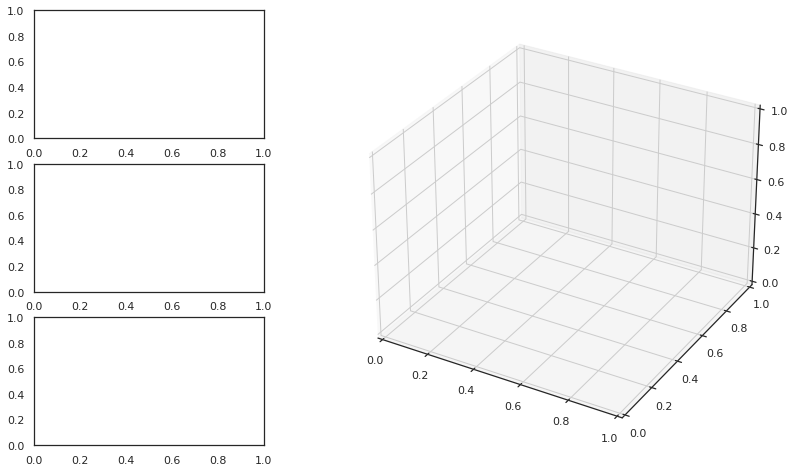

In [9]:
fig = plt.figure(figsize=(14,8))
ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((3, 3), (1, 0), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((3, 3), (2, 0), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((3, 3), (0, 1), rowspan=3, colspan=2, projection='3d')

In [10]:
res_list= []
for t_idx, _ in enumerate(net.cell_response.times):
    res = dask.delayed(make_hnn_frame)(net, dpl, t_idx, fig, ax1, ax2, ax3, ax4)
    res_list.append(res)

# Run tasks
final_res = dask.compute(*res_list)

In [11]:
images = [f'frame{t_idx}.png' for t_idx in range(net.cell_response.times.shape[0])]
make_movie('../network_images/', 'network_movie_light.mp4', images)